In [1]:
import pandas as pd
import numpy as np
import kineticstoolkit.lab as ktk
import matplotlib.pyplot as plt

In [3]:
#Importation du fichier
df = pd.read_csv(r'C:\Users\Nathan\Desktop\Formation\Handicap_Neurologique\M1\Stage\Etude_M1HN\data\nappe de pression\1\P1_A_FRA.csv',
                 sep = ";",index_col="time ")
df = df.drop(df.iloc[:, 0:5],axis=1) #si on veut que CoP Ant
df.columns = ["cop_ml","cop_ant"]

if df["cop_ant"][:50].mean() <0:
    initial_ant = np.sqrt(df["cop_ant"][:50].mean() ** 2)
else :
    initial_ant = -df["cop_ant"][:50].mean()
    
if df["cop_ml"][:50].mean() <0:
    initial_ml = np.sqrt(df["cop_ml"][:50].mean() ** 2)
else :
    initial_ml = -df["cop_ml"][:50].mean()

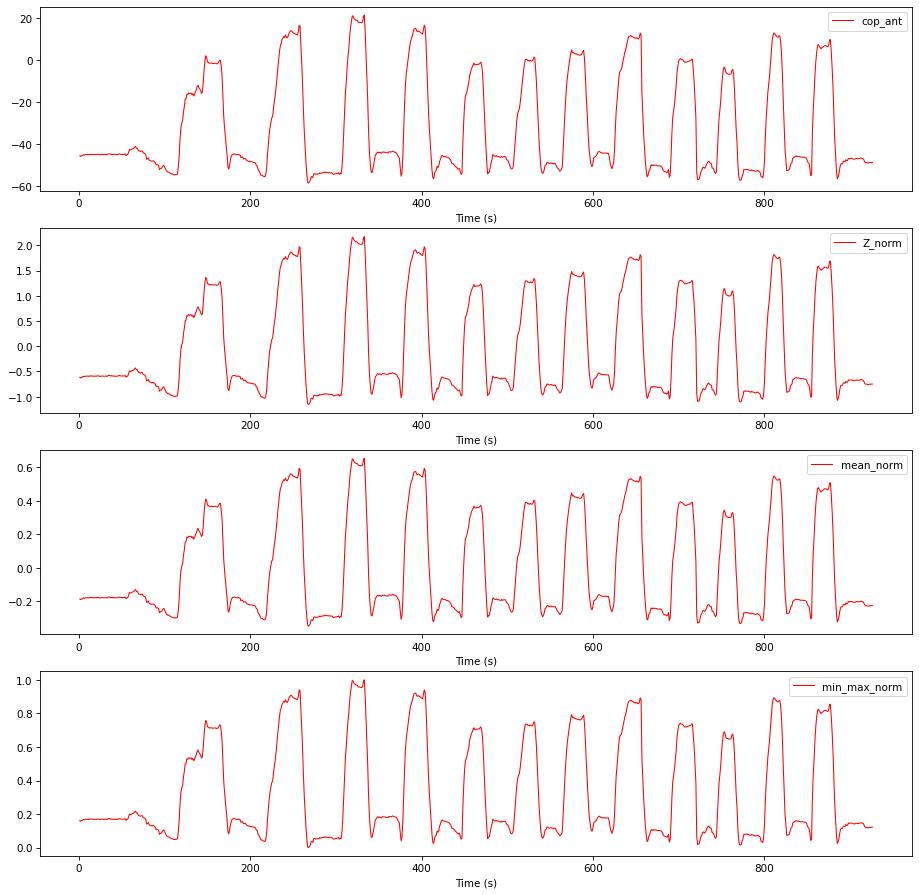

In [10]:
# TEST NORMALISATION 

df = pd.read_csv(r'C:\Users\Nathan\Desktop\Formation\Handicap_Neurologique\M1\Stage\Etude_M1HN\data\nappe de pression\1\P1_A_FRA.csv',
                 sep = ";",index_col="time ")
df = df.drop(df.iloc[:, 0:5],axis=1) #si on veut que CoP Ant
df.columns = ["cop_ml","cop_ant"]
if df["cop_ant"][:50].mean() <0:
    initial_ant = np.sqrt(df["cop_ant"][:50].mean() ** 2)
else :
    initial_ant = -df["cop_ant"][:50].mean()
    

# Z score normalisation : x' = [x-mean(x)] / std(x)
df['Z_norm'] = (df['cop_ant'] - df['cop_ant'].mean(axis=0)) / df['cop_ant'].std(axis=0)
# Normalisation par la moyenne : x'= [x-mean(x)] / [max(x)-min(x)]
df['mean_norm'] = (df['cop_ant']  - df['cop_ant'].mean(axis=0)) / (df['cop_ant'].max(axis=0) - df['cop_ant'].min(axis=0))
# Min max : x' = [x-min(x)] / [max(x)-min(x)]
df['min_max_norm']  = (df['cop_ant'] - df['cop_ant'].min(axis=0)) / (df['cop_ant'].max(axis=0) - df['cop_ant'].min(axis=0))

#Transformation du df en TimeSeries
ts = ktk.TimeSeries.from_dataframe(df)
plt.figure(figsize=(15,15))
plt.subplot(4,1,1)
ts.plot(['cop_ant'])
plt.subplot(4,1,2)
ts.plot(['Z_norm'])
plt.subplot(4,1,3)
ts.plot(['mean_norm'])
plt.subplot(4,1,4)
ts.plot(['min_max_norm'])

TimeSeries with attributes:
         time: <array of shape (926,)>
         data: <dict with 3 entries>
    time_info: <dict with 1 entries>
    data_info: <dict with 0 entries>
       events: <list of 0 items>

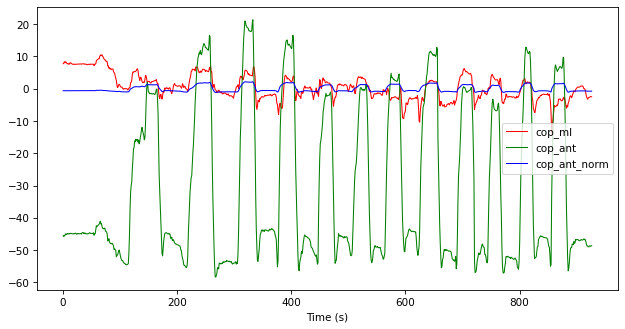

In [5]:
#Transformation du df en TimeSeries
ts = ktk.TimeSeries.from_dataframe(df)
ts.plot()
ts 

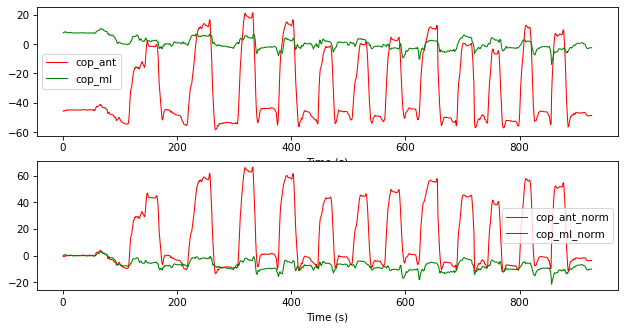

In [5]:
#Normalisation des data du CoP Ant 
ts.data["cop_ant_norm"] = ts.data["cop_ant"] + initial_ant
ts.data["cop_ml_norm"] = ts.data["cop_ml"] + initial_ml

plt.subplot(2,1,1)
ts.plot(["cop_ant","cop_ml"])
plt.subplot(2,1,2)
ts.plot(["cop_ant_norm","cop_ml_norm"])

In [6]:
# Définir les conditions de débuts et de fin d'un cycle

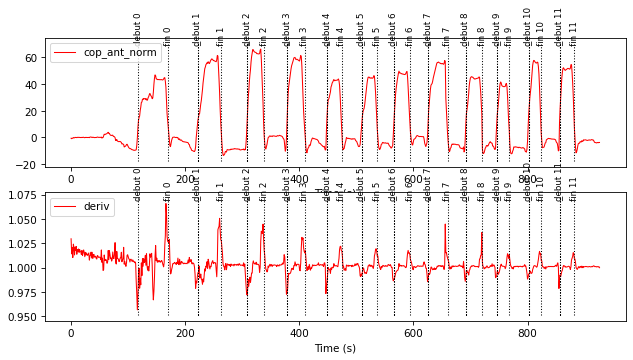

In [7]:
# Test avec la dérivé :
    # quand la dérivé passe de - à + => minimum
    # quand la dérivé passe de + à - => maximum
    
def derive(x1,y1,x2,y2):
    yp = (y2 - y1) / (x2 - x1)
    return yp

deriv = []
for i in range(0,925):
    deriv.append(derive(i,i+1,df.iloc[i,1],df.iloc[i+1,1]))
    
deriv.append(1)
deriv = np.array(deriv)
ts.data["deriv"] = deriv

#Visualisation sur le repérage classique des cycles pour voir si ça correspond 
ts_with_events = ktk.cycles.detect_cycles(
    ts, "cop_ant_norm", event_names=["debut", "fin"],thresholds=[10,10]
)

plt.subplot(2,1,1)
ts_with_events.plot("cop_ant_norm")
plt.subplot(2,1,2)
ts_with_events.plot("deriv")


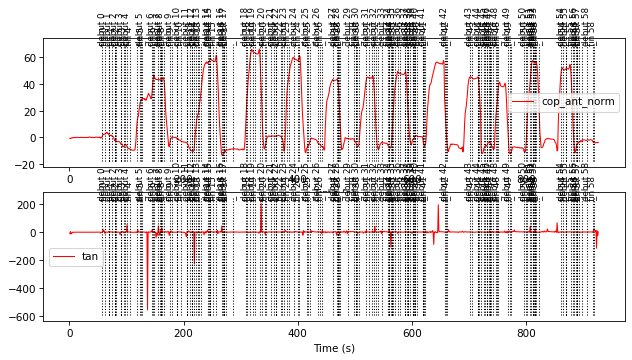

In [8]:
# Test avec la détection quand la tangente est nulle -> NE MARCHE PAS
from math import tan

tangente = []
for i in range(0,925):
    tangente.append(tan(df.iloc[i,1]))
    
tangente.append(0)
tangente = np.array(tangente)
ts.data["tan"] = tangente
ts_with_events = ktk.cycles.detect_cycles(
    ts, "tan", event_names=["debut", "fin"],
    thresholds=[0,0],
    min_durations=[2,2]    
)

plt.subplot(2,1,1)
ts_with_events.plot("cop_ant_norm")
plt.subplot(2,1,2)
ts_with_events.plot("tan")

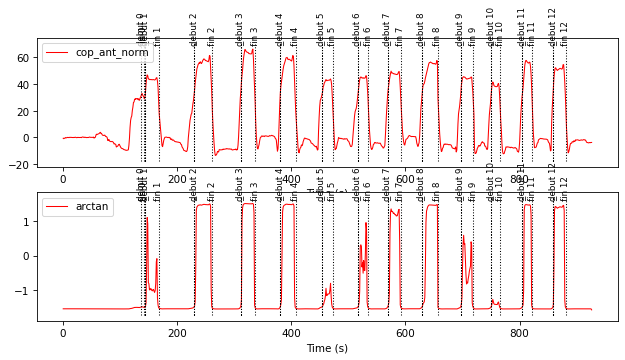

In [9]:
# Test avec la détection quand la tangente est nulle -> NE MARCHE PAS
arctan = []
for i in range(0,925):
    arctan.append(np.arctan(df.iloc[i,1]))
    
arctan.append(-1.58)
arctan = np.array(arctan)
ts.data["arctan"] = arctan
ts_with_events = ktk.cycles.detect_cycles(
    ts, "arctan", event_names=["debut", "fin"],
    thresholds=[-1.5,-1.5]   
)

plt.subplot(2,1,1)
ts_with_events.plot("cop_ant_norm")
plt.subplot(2,1,2)
ts_with_events.plot("arctan")


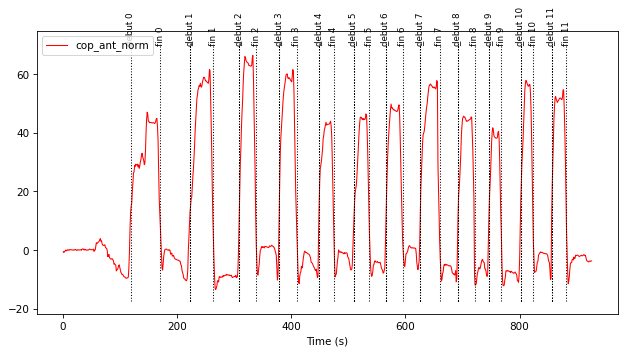

In [10]:
# Détection des cycles 
condition_debut_cycle = 10
condition_fin_cycle = 10

ts_with_events = ktk.cycles.detect_cycles(
    ts, "cop_ant_norm", event_names=["debut", "fin"],thresholds=[condition_debut_cycle,condition_fin_cycle]
)
ts_with_events.plot("cop_ant_norm")

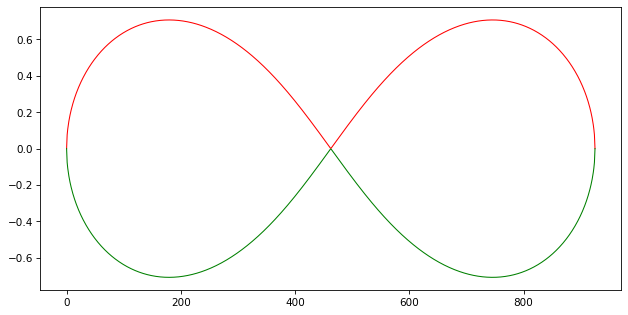

In [40]:
# Simulation d'un pattern de déplacement du FR au cours d'un test en 8 
list_x = []
yp = []
yn = []

for x in np.linspace(-2,2,926):
    yp.append(2/np.sqrt(2) * np.sqrt(np.sqrt(1 + 8 * (x/2)**2) - (1 + 2 * (x/2)**2)))
    yn.append(-2/np.sqrt(2) * np.sqrt(np.sqrt(1 + 8 * (x/2)**2) - (1 + 2 * (x/2)**2)))

# Visualisation
plt.plot(yp)
plt.plot(yn)

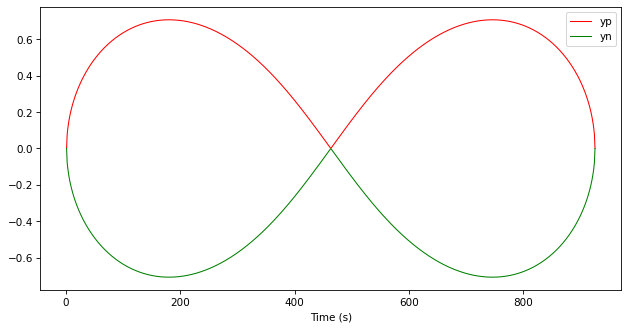

In [47]:
# Mise du test de 8 dans le TimeSerie
yp = np.array(yp)
yn = np.array(yn)
ts.data["yp"] = yp
ts.data["yn"] = yn



tps_demi_tour = 10
tps_ligne_droite = 10

ts.TimeSeriesEvent(time=tps_demi_tour, name='demi_tour')
ts.TimeSeriesEvent(time=tps_ligne_droite , name='ligne_droite')
ts.plot(['yp','yn'])

In [54]:

ts.time[ts.data['yp']==max(ts.data['yp'])]

array([180, 747], dtype=int64)